In [1]:
# LangGraph
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

# LangChain core
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool

# Models & embeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_cohere import CohereRerank

# Vector store
from langchain_chroma import Chroma

# Document loading & splitting
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Retrieval
from langchain_community.retrievers import BM25Retriever
#from langchain_community.retrievers.contextual_compression import ContextualCompressionRetriever


# Utilities
from typing import Literal
from dotenv import load_dotenv
from IPython.display import Image, display
import os
import re


c:\Users\Dell\Desktop\ai_engineering_repo\new_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print("✅ API key loaded")

✅ API key loaded


In [3]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.5,
    api_key=openai_api_key
)

print(f"✅ LLM initialized: {llm.model_name}")

✅ LLM initialized: gpt-4o-mini


In [4]:
# Load and process all 7 PDFs

DATA_DIR = r"C:\Users\Dell\Desktop\ai_engineering_repo\month_4\capstone_project\Tax_law_pdf_folder"

docs = []

for file in os.listdir(DATA_DIR):
    if file.lower().endswith(".pdf"):
        loader = PyPDFLoader(os.path.join(DATA_DIR, file))
        docs.extend(loader.load())

print(f"✅ Loaded {len(docs)} pages from {len(set(d.metadata['source'] for d in docs))} files")



✅ Loaded 459 pages from 7 files


In [5]:
#  Split the documents into smaller chunks (Optimized for legal documents)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    separators=["\n\n", "\n","ARTICLE", "SECTION", " ", ""]
)
# Split documents into chunks
doc_splits = text_splitter.split_documents(docs)
print(f"✅ Split into {len(doc_splits)} chunks.")
print(f"\nSample chunk:")
print(f"\n{doc_splits[0].page_content[:500]}...")

✅ Split into 1049 chunks.

Sample chunk:

ANALYSIS OF THE 
NIGERIAN TAX REFORM BILLS
BILL ANALYSIS
REVIEW OF RELEVANT INFORMATION ON NIGERIA’S DEMOCRACY
Issue 01, January 2025
INTRODUCTION
On 3 October 2024, President Bola Ahmed Tinubu transmitted the following Tax Bills to the National 
Assembly:
a. Nigeria Tax Administration Bill (HB. 1756);
b. National Tax Bill (HB. 1759)
c. Nigeria Revenue Service Bill (HB. 1757);
d. Joint Revenue Board Bill (HB. 1758).
This factsheet contains an analysis of these Tax Reform Bills. The analysis outl...


In [6]:
# Initialize embeddings (using OpenAIEmbeddings)
embedding_model = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=openai_api_key
)
print(" Embeddings model initialized.")

 Embeddings model initialized.


In [7]:
# Create Chroma vector store
Chroma_path = "./chroma_tax_law_db"

# Create vector store from documents
vector_store = Chroma(
    collection_name= "tax_law_documents",
    embedding_function = embedding_model,
    persist_directory = Chroma_path
)

# Add documents
vector_store.add_documents(documents = doc_splits)
print(f"✅ Vector store created with {len(doc_splits)} chunks.")
print(f" Chroma DB path: {Chroma_path}")

✅ Vector store created with 1049 chunks.
 Chroma DB path: ./chroma_tax_law_db


In [8]:
# Load vector store
vector_store = Chroma(
    collection_name= "tax_law_documents",
    embedding_function = embedding_model,
    persist_directory = "./chroma_tax_law_db"
)

print("✅ Vector store loaded successfully.")

✅ Vector store loaded successfully.


In [9]:
# Test the vector store with a sample query
query = "What are the tax implications of selling a primary residence?"
results = vector_store.similarity_search(query, k=2)

print(f"Query: {query}\n")
print("Top Results:")
print(f"{results[0].page_content[:200]}...")
print("✅ Vector store query test completed.")

Query: What are the tax implications of selling a primary residence?

Top Results:
Relevant Case Studies.. Cont..
Individual: Obinna Oladosu
Occupation: Senior Analyst
Annual Income: ₦8.5 million
Annual Rent Paid: ₦1.5 million
Scenario:
Under new PIT rules:
• CRA is removed
• Rent r...
✅ Vector store query test completed.


In [10]:
# Create a retrieval tool
@tool
def tax_law_retrieval_tool(query: str) -> str:
    """Retrieve relevant tax law documents based on the query.
    Use this tool to get information about tax laws and regulations. Do Not use this tool for other
    - General inquiries unrelated to tax law.
    - Personal advice or opinions.
    - Medical, legal, or financial advice.
    - Any other non-tax-law-related topics.
    
    Args:
        query (str): The user's query describing what information is needed.
    Returns:
        str: The relevant excerpts that can help answer the query.
    """
    # Use MMR for diverse results
    retriever = vector_store.as_retriever(
        search_type="mmr", 
        search_kwargs={"k": 5, "fetch_k": 10}
    )
    
    # Retrieve documents
    results = retriever.invoke(query)
    
    # Format results
    formatted_results = "\n\n---\n\n".join(
        f"Document {i+1}:\n{doc.page_content}" 
        for i, doc in enumerate(results)
    )
    return formatted_results
print("✅ Retrieval tool created successfully.")

 

✅ Retrieval tool created successfully.


In [11]:
# Test the retrieval tool
test_result = tax_law_retrieval_tool.invoke({"query": "What are the tax implications of selling a primary residence?"})
print(f"Tool result (first 300 chars):\n{test_result[:300]}...")

Tool result (first 300 chars):
Document 1:
Relevant Case Studies.. Cont..
Individual: Obinna Oladosu
Occupation: Senior Analyst
Annual Income: ₦8.5 million
Annual Rent Paid: ₦1.5 million
Scenario:
Under new PIT rules:
• CRA is removed
• Rent relief capped at ₦200,000
• Obinna now in a higher tax bracket compared 
to the old rules...


In [12]:
# Create the system prompt
system_prompt = SystemMessage(content="""You are a Nigerian Tax Reform Expert Assistant. Your job is to:
1. **Accuracy First**: Only answer from the retrieved documents.
2. **Cite Everything**: Reference specific sections (e.g., "Section 25(3) of the Nigeria Tax Bill")
3. **Simplify Complex Language**: Translate legal jargon to plain English
4. **Compare Old vs New**: When relevant, explain what changed
5. **Address Misinformation**: If the question contains false assumptions, correct them gently
6. **Be Practical**: Give examples (Aunty Ngozi's restaurant, Chidi's salary)
7. **Show Calculations**: For tax amounts, show the math

Format:
- Start with a direct answer
- Explain the reasoning
- Provide specific citations
- Add a practical example if helpful
- Include relevant timeline (when it takes effect)

If you don't know or the documents don't contain the info, say so clearly.
""")  

print("✅ System prompt created.")

✅ System prompt created.


In [13]:
# Bind tools and LLM
tools = [tax_law_retrieval_tool]
llm_with_tools = llm.bind_tools(tools)

def assistant(state: MessagesState) -> dict:
    """
    Assistant node - decides whether to retrieve or answer directly.
    """
    messages = [system_prompt] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """
    Decide whether to call tools or end the conversation.
    """
    last_message = state["messages"][-1]
    
    if last_message.tool_calls:
        return "tools"
    return "__end__"

print("✅ Agent nodes created.")

✅ Agent nodes created.


In [14]:
# Build the state graph
builder = StateGraph(MessagesState)

# Add nodes to the graph
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {
        "tools": "tools","__end__": END}
)
builder.add_edge("tools", "assistant")

# Add memory saver
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

print("✅ Agentic RAG system compiled..")

✅ Agentic RAG system compiled..


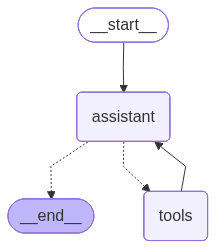

In [15]:
# Visualize the agentic RAG graph
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("Graph: START -> assistant -> [if tool_call]-> tools -> assistant -> ... -> END")
    

In [16]:
from langchain_core.messages import HumanMessage, AIMessage

def query_agent(user_input: str, thread_id: str = "default_session"):
    """
    Improved query function with correct final-answer handling.
    """

    print(f"\n{'='*70}")
    print(f" User: {user_input}\n")
    print(f"{'-'*70}\n")

    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )

    used_retrieval = False
    final_answer = None

    for message in result["messages"]:
        if isinstance(message, AIMessage):
            # Detect retrieval/tool usage
            if message.tool_calls:
                used_retrieval = True
                print(" Agent: [Calling retrieval tool...]")

            # Capture FINAL answer (AI message with content and no tool calls)
            if message.content and not message.tool_calls:
                final_answer = message.content

    # Always print final answer
    if final_answer:
        print(f"\n Agent Final Answer:\n{final_answer}\n")
    else:
        print(" No final answer was produced by the agent.")

    # Summary
    print(f"{'-'*70}")
    print(f" Decision: {'USED RETRIEVAL' if used_retrieval else 'DIRECT ANSWER'}")
    print(f"{'='*70}\n")


In [17]:
query_agent("How much is the VAT on small businesses?", thread_id="session_1")


 User: How much is the VAT on small businesses?

----------------------------------------------------------------------

 Agent: [Calling retrieval tool...]

 Agent Final Answer:
The Value Added Tax (VAT) in Nigeria is set at 7.5% for all taxable goods and services. Small businesses are required to charge this VAT on their sales and remit it to the Nigerian Revenue Service (NRS). 

### Explanation
- **VAT Rate**: The standard VAT rate is 7.5%.
- **Small Business Definition**: Under the new provisions, a "small company" is defined as one with a gross turnover of ₦50,000,000 or less per annum and total fixed assets not exceeding ₦250,000,000. However, businesses providing professional services are excluded from this classification and the related incentives.

### Citation
This information is derived from **Document 5**, which outlines the definition of small companies and the VAT requirements.

### Practical Example
For instance, if Aunty Ngozi runs a small restaurant and sells a meal f

In [18]:
# General Knowlwedge
query_agent("What can you help me with?", thread_id="session_2")


 User: What can you help me with?

----------------------------------------------------------------------


 Agent Final Answer:
I can assist you with information regarding Nigerian tax laws, including:

1. **Understanding Tax Regulations**: Explaining specific tax laws and their implications.
2. **Comparing Old and New Tax Laws**: Highlighting changes in tax regulations and what they mean for individuals and businesses.
3. **Calculating Taxes**: Helping you understand how to calculate taxes based on current laws.
4. **Providing Examples**: Giving practical examples to illustrate tax concepts.
5. **Clarifying Legal Terms**: Simplifying complex legal language related to taxes.

Feel free to ask specific questions about tax laws, and I'll provide accurate information based on the relevant documents!

----------------------------------------------------------------------
 Decision: DIRECT ANSWER



In [19]:
# Follow up question
query_agent("Can you explain the tax brackets for individuals?", thread_id="session_3") 


 User: Can you explain the tax brackets for individuals?

----------------------------------------------------------------------

 Agent: [Calling retrieval tool...]

 Agent Final Answer:
The tax brackets for individuals in Nigeria have been updated as follows:

1. **First N800,000**: Taxed at **0%** (no tax).
2. **Next N2,200,000** (from N800,001 to N3,000,000): Taxed at **15%**.
3. **Next N9,000,000** (from N3,000,001 to N12,000,000): Taxed at **18%**.
4. **Next N13,000,000** (from N12,000,001 to N25,000,000): Taxed at **21%**.
5. **Next N25,000,000** (from N25,000,001 to N50,000,000): Taxed at **23%**.
6. **Above N50,000,000**: Taxed at **25%**.

**Reasoning**: These brackets mean that each portion of your income is taxed at a different rate. For example, if you earn N15,000,000, you won't pay 18% on the whole amount; instead, you'll pay 0% on the first N800,000, 15% on the next N2,200,000, and so forth.

**Citations**: This information is outlined in the Nigeria Tax Act, 2025, spe